In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image, ImageOps, ImageDraw
from create_dataset import ClimbingHoldDataset
from collections import defaultdict
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from pycocotools import mask as maskUtils

In [5]:
hues = np.load('hues.npy').reshape(-1,1)

In [6]:
# Create the dataset
dataset = ClimbingHoldDataset(annotations_dir="data/annotations", 
                               images_dir="data/images")

dataset.add_color(hues)

dataset.add_type()          
dataset.add_orientation()   

dataset_pd = pd.DataFrame(dataset.holds)

In [7]:
dataset_pd = pd.DataFrame(dataset.holds)
dataset_pd.head()

dataset_pd["type"] = [h["type"] for h in dataset.holds]
dataset_pd["orientation"] = [h["orientation"] for h in dataset.holds]


In [8]:
img_list = dataset_pd['image_id'].unique()

In [9]:
kmeans = KMeans(init="random", 
                n_clusters=3, 
                n_init=10, 
                max_iter=300, 
                random_state=42)

In [10]:
img_id = img_list[1]
img_dataset = dataset_pd[(dataset_pd['image_id'] == img_id)]

In [11]:
route_list = img_dataset['route_id'].unique()
print(route_list)

[203. 204. 202.]


In [ ]:
features = img_dataset['color'].to_numpy().reshape(-1,1)
types  = img_dataset['type_idx'].to_numpy().reshape(-1,1)

features = np.hstack([features, types])

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
kmeans.fit(scaled_features)
preds = kmeans.labels_

img_dataset = img_dataset.copy()   
img_dataset["cluster"] = preds

print("\n=== K-MEANS CLUSTER ASSIGNMENTS ===")
print(img_dataset[["color", "type_idx", "cluster"]])


print("\nUnique clusters:", img_dataset["cluster"].unique())


print("\nCounts per cluster:")
print(img_dataset["cluster"].value_counts())


=== K-MEANS CLUSTER ASSIGNMENTS ===
         color  type_idx  cluster
15   13.630610         4        1
16    9.607370         3        1
17   12.751141         2        1
18   13.124238         2        1
19   10.862960         3        1
20    8.416667         3        1
21    6.585574         3        1
22    4.224040         3        1
23    5.616832         3        1
24    5.452741         3        1
25    6.723280         3        1
26    6.288443         3        1
27   11.422604         3        1
28    9.164354         0        0
29    8.613927         0        0
30   13.948393         0        0
31   10.504164         2        1
32   12.500033         0        0
33    9.796598         0        0
34    7.511018         3        1
35   13.004683         3        1
36   10.885848         0        0
37    8.385723         0        0
38   59.411093         0        0
39  140.492912         0        2
40   82.594020         1        2
41  107.912737         0        2
42  109.118

In [16]:
def display_masked_image(img_path, rles):
    img = Image.open(img_path).convert("RGB")
    img = ImageOps.exif_transpose(img)

    h, w = img.shape[:2]

    combined_mask = np.zeros((h, w), dtype=np.uint8)

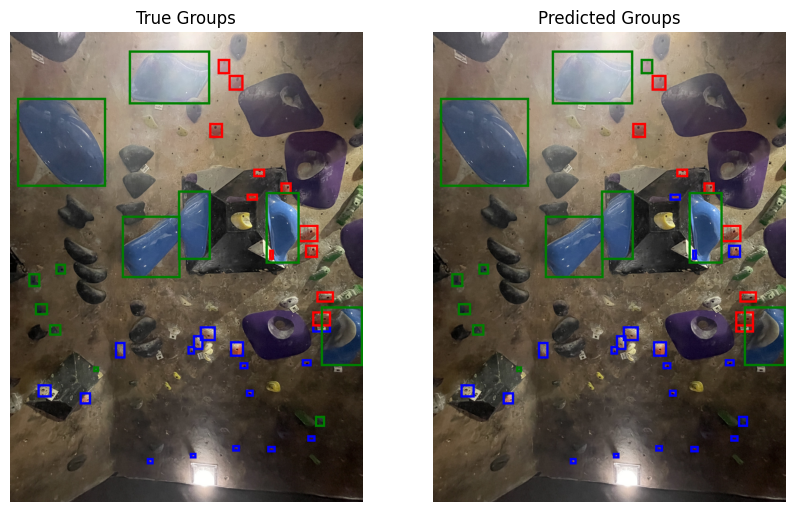

In [17]:
images_dir = 'data/images'
img_path = os.path.join(images_dir, img_id)

img = Image.open(img_path).convert("RGB")
img = ImageOps.exif_transpose(img)

image_with_boxes_pred = img.copy()
draw_pred = ImageDraw.Draw(image_with_boxes_pred)

colors = {0:'red', 1:'blue', 2:'green', 3:'yellow', 4:'purple'}

for i, bbox in enumerate(img_dataset['bbox']):
    x, y, width, height = bbox
    label = preds[i]
    color = colors[label]
    draw_pred.rectangle([x, y, x + width, y + height], outline=color, width=20)

image_with_boxes_true = img.copy()
draw_true = ImageDraw.Draw(image_with_boxes_true)

colors = {202:'green', 203:'blue', 204:'red', 3:'yellow', 4:'purple'}

for route, bbox in zip(img_dataset['route_id'], img_dataset['bbox']):
    x, y, width, height = bbox
    label = route
    color = colors[label]
    draw_true.rectangle([x, y, x + width, y + height], outline=color, width=20)

# Display the image with bounding boxes
f, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(image_with_boxes_true)
ax[0].set_title("True Groups")
ax[0].axis("off")
ax[1].imshow(image_with_boxes_pred)
ax[1].set_title("Predicted Groups")
ax[1].axis("off")
plt.show()



In [18]:
def visualize_hues(hues):
    for H in hues[:100]:
        # Make a strip of HSV values where hue = your hue
        hsv_strip = np.zeros((50, 200, 3), dtype=np.uint8)
        hsv_strip[..., 0] = H      # Hue
        hsv_strip[..., 1] = 255    # Full saturation
        hsv_strip[..., 2] = 255    # Full brightness

        # Convert to RGB for proper display
        rgb_strip = cv2.cvtColor(hsv_strip, cv2.COLOR_HSV2RGB)

        plt.figure(figsize=(2,2))
        plt.imshow(rgb_strip)
        plt.title(f"Hue = {H}")
        plt.axis('off')
        plt.show()

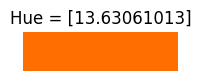

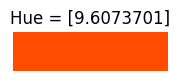

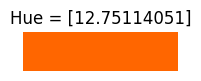

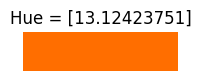

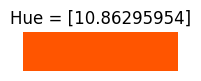

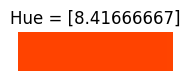

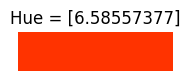

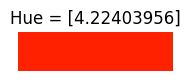

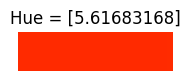

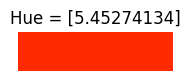

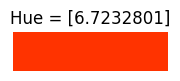

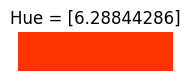

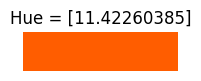

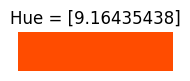

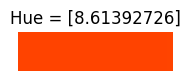

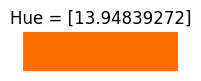

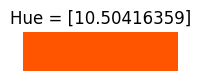

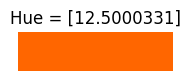

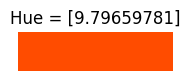

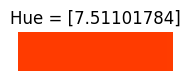

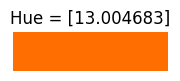

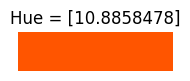

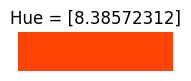

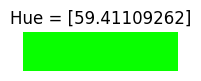

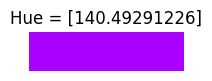

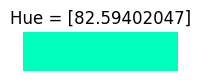

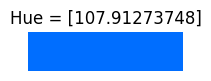

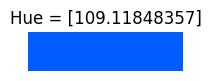

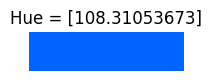

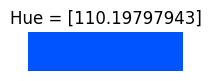

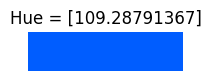

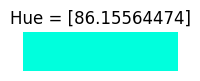

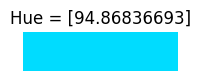

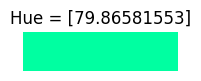

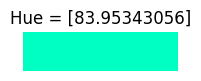

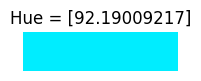

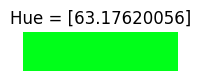

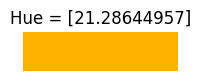

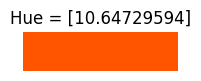

In [ ]:
visualize_hues(features)

In [ ]:
def print_sample_hold(sample):
    # sample = dataset[500] # change to whatever number you want
    
    # # Denormalize the image
    # mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
    # std = torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1)
    # img = sample["image"] * std + mean
    # img = img.clamp(0, 1)

    # pil_img = transforms.ToPILImage()(img)

    # display(pil_img)
    print("\nSample Hold:")
    # print(f"Parent image id: {sample['parent_image_id']}")
    print(f"Route ID: {sample['route_id']}")
    # print(f"Image shape: {sample['image'].shape}")
    print(f"Hold Type (index): {sample['type']}")
    print(f"Hold Orientation (index): {sample['orientation']}")
    print(f'Color: {sample['color']}')

# # Print one sample hold from both training and validation sets
# print("\nSample Hold from Training Set:")
print_sample_hold(holds_by_image['IMG_7280.JPG'][2])


Sample Hold:
Route ID: 2.0
Hold Type (index): Jug
Hold Orientation (index): UpAng
Color: [110.85855326]
